In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('yellow_tripdata_2016-01.csv.zip')

In [3]:
original = df.copy()

In [4]:
df.shape

(10906858, 19)

**sampling the df since it's too big:**

In [5]:
df.sort_values(by='tpep_pickup_datetime')
df = df.iloc[:100000, :]

In [6]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

In [7]:
relevant_feats = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_longitude',
                  'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount']

coordinates_feats = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

In [8]:
df.sample(5)[relevant_feats].T

,25926,58191,81196,97739,87007
tpep_pickup_datetime,2016-01-02 04:20:55,2016-01-29 12:04:00,2016-01-01 01:28:35,2016-01-01 02:03:54,2016-01-01 01:40:48
tpep_dropoff_datetime,2016-01-02 04:35:53,2016-01-29 12:12:25,2016-01-01 01:46:03,2016-01-01 02:07:39,2016-01-01 01:56:19
passenger_count,1,2,2,1,3
trip_distance,4.19,0.53,4.23,1.41,2.96
pickup_longitude,-73.981598,-73.958992,-73.973228,-73.969261,-74.014771
pickup_latitude,40.738239,40.771809,40.755219,40.749626,40.70974
dropoff_longitude,-73.984062,-73.963959,-74.010246,-73.956993,-74.00177
dropoff_latitude,40.782249,40.771156,40.714184,40.767227,40.74353
fare_amount,15.0,6.5,15.0,6.0,13.0


leakage - 'tpep_dropoff_datetime',
enrich - 'trip_distance' (external API, euclidean / manhattan)
valid - 'tpep_pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

**converting datetime features to be of type datetime and creating the target for the duration predictions model:**

In [9]:
df['pickup_datetime'] = df['tpep_pickup_datetime'].astype('datetime64')
df['dropoff_datetime'] = df['tpep_dropoff_datetime'].astype('datetime64')

In [10]:
df['pickup_day'] = df['pickup_datetime'].dt.day_of_week
df['dropoff_day'] = df['dropoff_datetime'].dt.day_of_week

In [11]:
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['dropoff_hour'] = df['dropoff_datetime'].dt.hour

In [12]:
df['pickup_minute'] = df['pickup_datetime'].dt.minute
df['dropoff_minute'] = df['dropoff_datetime'].dt.minute

In [13]:
df['duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).apply(lambda td: td.seconds/60)
df['duration'].sample(5)

2507     29.316667
19743     3.816667
40116    13.600000
3413     11.116667
32254    18.733333
Name: duration, dtype: float64

In [14]:
duration_target = 'duration'

In [15]:
engineered_feats = ['dropoff_datetime', 'pickup_datetime', 'pickup_day', 'dropoff_day', 
                    'pickup_hour', 'dropoff_hour', 'pickup_minute', 'dropoff_minute', 'duration']
relevant_feats.extend(engineered_feats)

relevant_feats.remove('tpep_dropoff_datetime')
relevant_feats.remove('tpep_pickup_datetime')
relevant_feats

['passenger_count',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'fare_amount',
 'dropoff_datetime',
 'pickup_datetime',
 'pickup_day',
 'dropoff_day',
 'pickup_hour',
 'dropoff_hour',
 'pickup_minute',
 'dropoff_minute',
 'duration']

**integrity checks:**

In [50]:
(df['pickup_datetime'] < df['dropoff_datetime']).value_counts()

True    66852
dtype: int64

In [51]:
(df['fare_amount'] > 0).value_counts()

True    66852
Name: fare_amount, dtype: int64

In [52]:
(df['trip_distance'] > 0).value_counts()

True    66852
Name: trip_distance, dtype: int64

In [21]:
len(df['passenger_count'] > 0)

100000

In [56]:
df['passenger_count'].value_counts()

1    51807
2    15045
Name: passenger_count, dtype: int64

In [23]:
for feat in coordinates_feats:
    print(f'{feat}: {(df[feat] == 0).sum()}')

pickup_longitude: 1548
pickup_latitude: 1548
dropoff_longitude: 1484
dropoff_latitude: 1484


**dropping off invalid data:**

In [24]:
df.shape

(100000, 28)

In [25]:
df = df[df['pickup_datetime'] < df['dropoff_datetime']]

In [26]:
df.shape

(99869, 28)

In [27]:
df = df[df['fare_amount'] > 0]

In [28]:
df.shape

(99767, 28)

In [29]:
df = df[df['trip_distance'] > 0]

In [30]:
df.shape

(99078, 28)

In [31]:
df = df[np.logical_or(df['passenger_count'] == 2, df['passenger_count'] == 1)]

In [32]:
df['passenger_count'].value_counts()

1    62742
2    18363
Name: passenger_count, dtype: int64

In [33]:
df.shape

(81105, 28)

In [34]:
indices0 = df[coordinates_feats].isin([0]).any(axis=1)
df = df[~indices0]

In [35]:
df.shape

(79905, 28)

**some visualizations:**

<ipython-input-36-0973ddab7f8f>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


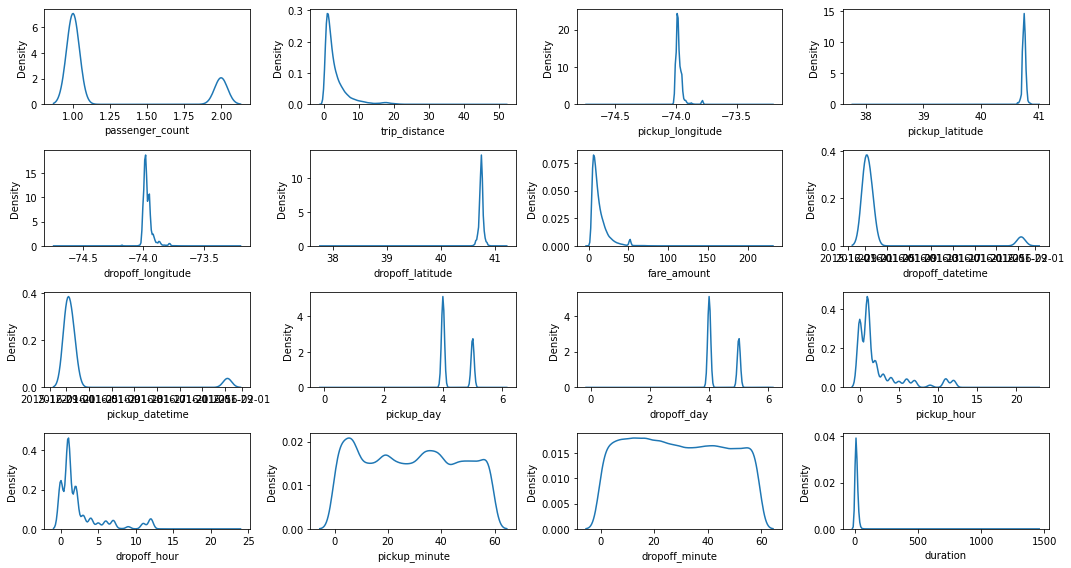

In [36]:
fig = plt.figure(figsize=(15, 8))

for i, feat in enumerate(relevant_feats):        
    plt.subplot(4, 4, i + 1)
    sns.kdeplot(df[feat])
    
fig.tight_layout()
fig.show()

**taking care of outliers in these features:**

- trip_distance
- fare_amount
- duration
- coordinates features

In [37]:
copy = df.copy()

In [38]:
outliers_feats = ['trip_distance', 'fare_amount', 'duration']
outliers_feats.extend(coordinates_feats)
for feat in outliers_feats:
    Q1 = copy[feat].quantile(.25)
    Q3 = copy[feat].quantile(.75)
    IQR = Q3 - Q1
    
    bottom_bound = Q1 - 1.5 * IQR
    top_bound = Q3 + 1.5 * IQR
    
    print(f'{feat}\nbottom: {bottom_bound}\ttop: {top_bound}\nIQR: {IQR}\n')
    
    print(f'shape before: {df.shape}')
    df = df[df[feat].between(bottom_bound, top_bound)]
    print(f'shape after: {df.shape}\n')

trip_distance
bottom: -3.22	top: 8.54
IQR: 2.94

shape before: (79905, 28)
shape after: (73795, 28)

fare_amount
bottom: -7.75	top: 30.25
IQR: 9.5

shape before: (73795, 28)
shape after: (73474, 28)

duration
bottom: -10.524999999999995	top: 34.34166666666666
IQR: 11.216666666666665

shape before: (73474, 28)
shape after: (72669, 28)

pickup_longitude
bottom: -74.03053665161133	top: -73.92705154418945
IQR: 0.02587127685546875

shape before: (72669, 28)
shape after: (70318, 28)

pickup_latitude
bottom: 40.67900466918945	top: 40.81898880004883
IQR: 0.03499603271484375

shape before: (70318, 28)
shape after: (68780, 28)

dropoff_longitude
bottom: -74.04473876953122	top: -73.89843750000003
IQR: 0.03657531738279829

shape before: (68780, 28)
shape after: (67990, 28)

dropoff_latitude
bottom: 40.66801643371582	top: 40.83395576477051
IQR: 0.041484832763671875

shape before: (67990, 28)
shape after: (66852, 28)



C:\Users\haimk\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\haimk\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\haimk\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\haimk\anaconda3\lib\si

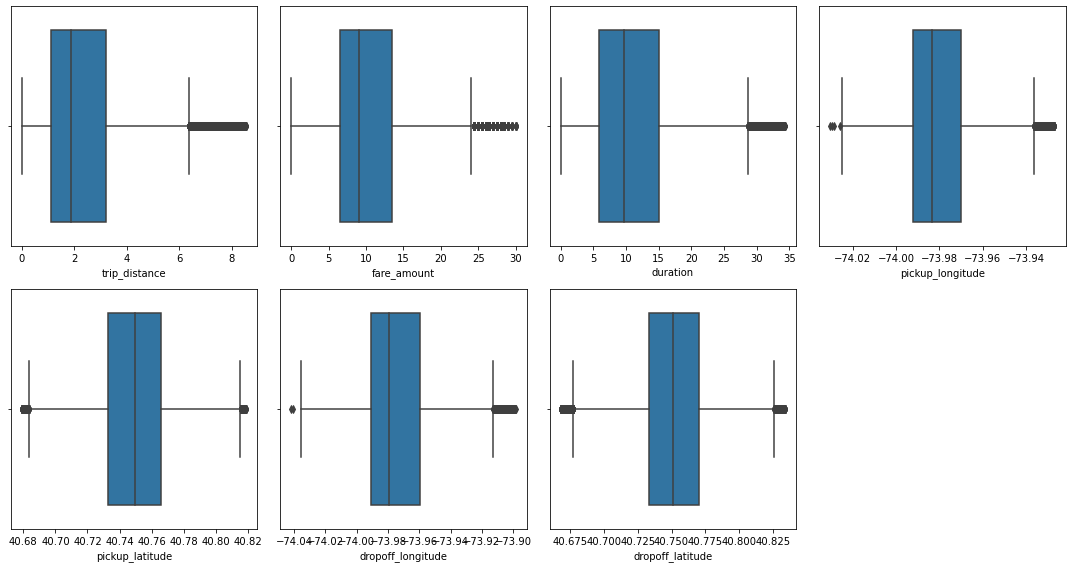

In [39]:
fig = plt.figure(figsize=(15, 8))

for i, feat in enumerate(outliers_feats):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(df[feat])
    plt.xlabel(feat)

fig.tight_layout()
fig.show()

In [40]:
df[relevant_feats].describe().T

,count,mean,std,min,25%,50%,75%,max
passenger_count,66852.0,1.225049,0.417618,1.000000,1.000000,1.000000,1.000000,2.000000
trip_distance,66852.0,2.360732,1.697884,0.010000,1.100000,1.860000,3.200000,8.540000
pickup_longitude,66852.0,-73.980936,0.017202,-74.030319,-73.992378,-73.983604,-73.969986,-73.927055
pickup_latitude,66852.0,40.750405,0.024013,40.679062,40.733002,40.749926,40.766010,40.818981
dropoff_longitude,66852.0,-73.975416,0.021840,-74.041809,-73.990990,-73.979271,-73.959679,-73.898506
dropoff_latitude,66852.0,40.751538,0.028762,40.668018,40.733093,40.751389,40.770230,40.833935
fare_amount,66852.0,10.453990,5.272318,0.010000,6.500000,9.000000,13.500000,30.000000
pickup_day,66852.0,4.339436,0.476168,0.000000,4.000000,4.000000,5.000000,6.000000
dropoff_day,66852.0,4.339436,0.476168,0.000000,4.000000,4.000000,5.000000,6.000000
pickup_hour,66852.0,2.166233,3.063810,0.000000,0.000000,1.000000,2.000000,22.000000


In [41]:
df[relevant_feats].describe(exclude=np.number).T

<ipython-input-41-3b21a08b2d65>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df[relevant_feats].describe(exclude=np.number).T
<ipython-input-41-3b21a08b2d65>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df[relevant_feats].describe(exclude=np.number).T


,count,unique,top,freq,first,last
dropoff_datetime,66852,25243,2016-01-01 01:17:08,16,2016-01-01 00:01:17,2016-01-29 12:42:52
pickup_datetime,66852,22753,2016-01-01 00:32:43,17,2016-01-01 00:00:00,2016-01-29 12:08:57


In [42]:
from sklearn.preprocessing import StandardScaler

In [43]:
output_feats = ['pickup_day', 'pickup_hour', 'pickup_minute', 'passenger_count', 'trip_distance', 
               'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
               'fare_amount', 'duration']

In [44]:
to_scale = df[output_feats]
scaler = StandardScaler()
scaler.fit(to_scale)
scaled_data = scaler.transform(to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=output_feats)

In [45]:
price_feats = ['pickup_day', 'pickup_hour', 'pickup_minute', 'passenger_count', 'trip_distance', 
               'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
               'fare_amount']

duration_feats = ['pickup_day', 'pickup_hour', 'pickup_minute', 'trip_distance', 
                  'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                  'duration']

In [46]:
price_output = scaled_df[price_feats]
price_output.head()

,pickup_day,pickup_hour,pickup_minute,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount
0,-0.712856,-0.707044,-1.617379,1.855659,1.860723,0.047550,-0.306325,2.835430,0.403426,1.620933
1,-0.712856,-0.707044,-1.617379,1.855659,2.997441,-0.762775,-1.266622,0.414554,1.332761,2.948632
2,-0.712856,-0.707044,-1.617379,-0.538892,-0.683640,0.087911,-0.241193,-0.760951,0.083656,-0.275780
3,-0.712856,-0.707044,-1.617379,-0.538892,0.500196,-1.012038,-1.103952,-0.935617,-2.195185,0.198398
4,-0.712856,-0.707044,-1.617379,-0.538892,-0.925119,-1.465767,-0.228484,-0.841647,-0.351103,-0.844794


In [47]:
compression_opts = dict(method='zip', archive_name='price_model_data.csv')
price_output.to_csv('price_model_data.zip', compression=compression_opts)

In [48]:
duration_output = scaled_df[duration_feats]
duration_output.head()

,pickup_day,pickup_hour,pickup_minute,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,duration
0,-0.712856,-0.707044,-1.617379,1.860723,0.047550,-0.306325,2.835430,0.403426,1.087660
1,-0.712856,-0.707044,-1.617379,2.997441,-0.762775,-1.266622,0.414554,1.332761,2.301171
2,-0.712856,-0.707044,-1.617379,-0.683640,0.087911,-0.241193,-0.760951,0.083656,0.116852
3,-0.712856,-0.707044,-1.617379,0.500196,-1.012038,-1.103952,-0.935617,-2.195185,-0.000822
4,-0.712856,-0.707044,-1.617379,-0.925119,-1.465767,-0.228484,-0.841647,-0.351103,-0.711767


In [49]:
compression_opts = dict(method='zip', archive_name='duration_model_data.csv')
duration_output.to_csv('duration_model_data.zip', compression=compression_opts)